# PROSJEKT 2 _____________________

# Ship Stability blabla


**TING Å ORDNE**
- likningsreferanse funker nå bare i samme celle... Gamlemåten?

- Laste opp gifs på nett og sette inn lenker!!!!!!!!!

- update figure count

- add text to all figures




## Contents
* [Introduction](#intro)
* [Theory behind methods](#method)
* [Model and assumptions](#model)
* [Code for visualization](#vis)
* [Harmonic oscillator with constant $A$](#constA)
* [Varying the displaced-water-area](#water)
* [Boat with cargo](#cargo)
* [Boat with friction and harmonic wave/wind-force](#w-force)
* [Comparing RK4 with an adaptive solver](#adaptive)
* [Conclusion](#conclusion)

## Introduction <a class="anchor" id="intro"></a>

The dynamics and stability of boats have for a long time been a subject of great interest to mankind. Making ships that remain stable with or without loads, in heavy waters and rough wind has therefore been important. For many years, the stability of boats came from the experience of boat-makers. Now, with the advent of computers that can solve large systems of differential equations, we can take a more scientific approach to this question. 

Finding analytic solutions to the coupled differential equations that model a general ship is a formidable task, and often an impossible one. There is, of course, always possible to linearize the equations and study the eigenvalues of the resulting system, but this approach has its drawbacks as well. Numerical solutions, on the other hand, is not that difficult to produce. In this notebook, we will model the dynamics of a ship using simple mechanics and numerical techniques. 

The notebook starts with a combination of math and code to explain the physical model which shall serve as the basis for our discussion. To make the notebook more readable, the simulations and animations will be made incrementally more advanced, beginning with small amplitude, frictionless behaviour and ending with a model of friction and a load mass on deck.

The plots used in our discussion appear right beneath the code that produced it. The animations, however, have been uploaded to a private repository on imgur and included as a .gif from there. We elected to do it this way to be able to include animations without too much overhead for the reader. Our discussion will focus mainly on the plots, so the animations are only included to make the notebook more understandable and interesting. The code that made the animations appear as comments througout the notebook, and was commented out as they tend to have a comparable long runtime. Feel free to remake the plots as the code that solves the differential equations is quite fast.

We'll now introduce the the main numerical methods we are going to use, before we make the physical model that we will base our numerical simulations upon.



## Theory behind methods <a class="anchor" id="method"></a>

In [56]:
## Libraries for maths and plotting
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import norm 
from scipy.integrate import solve_ivp

## Library for status bar
from tqdm.notebook import tqdm

**Newtons method** <a class="anchor" id="newton_method"></a>



During the course of the simulations, we will need to solve implicit equations for equilibrium constants. To do this, we will use the fixed-point iteration method called Newtons method. This method converges very fast, as long as the initial guess is sufficiently close to the true value.

In [57]:
# 1a
def newton(f, df, x0, tol=1.e-10, max_iter=30, variable = "x", table = True):
    """
    brief: Solves the equation f(x)=0 with Newtons method
    :param f: the function f(x)
    :param df: the derivative of f(x)
    :param x0: initial value
    :param tol: tolerance, if f(x)<tol we accept x
    :return: the accepted root, number of iterations
    """
    x = x0
    for k in range(max_iter):
        if table:
            print(f"k ={k:3d}, {variable} = {x:18.15f}, f({variable}) = {f(x):10.3e}")
        fx = f(x)
        if norm(fx) < tol: # Accept solution 
            break 
        x = x - fx/df(x)   # One Newton-iteration
    return x, k+1

Newtons method is decined to have quadratic convergence, i.e. the total error converges as 
$$|e_{n+1}| < M|e_n|^2.$$
This is true if the function $f$ is twice continously differentiable and 

$$\frac{|f^{\prime \prime}(y)|}{|f^{\prime}(x)|} \leq 2M \,\forall x,y \in I_\delta$$
For some positive constant $M$ and an interval $I_\delta$ around the root of $f$ .

We will primarily use this method to solve the equation
$$
f(\beta) = \beta - \sin {\beta} - \pi \sigma / \sigma_0 = 0.
$$
With derivative 
$$f'(\beta) = 1 - \cos{\beta}.$$
and double derivative
$$f''(\beta) = \sin{\beta}.$$

This has a root between 2 radians and 3 radians (see plot under the models section). On this interval
$$
\begin{align*}
    \frac{|f^{\prime \prime}(y)|}{|f^{\prime}(x)|} = \frac{\sin{y}}{1-\cos{x}}
\end{align*}
$$
Since $\cos{x} \neq 1$ on the interval $x \in [2, 3]$, the above condition must hold on this interval. Newtons method will therefore converge towards the root

**Methods for solving ordinary differential equations**



The numerical techniques we will be using to solve the systems of ODE's that describe our boat, are Runge-Kutta methods. A Runge-Kutta method is an iterative method to approximate the solution of a sytem of ODE's. The general form of a Runge-Kutta method is:

$$
\begin{align*}
     y_{n+1} = y_n + h\sum_{i=1}^s b_i k_i.
  \end{align*}
$$

Where $y_{n+1}$ is the approximation of $y(t_{n+1})$, $h$ is the stepsize, and $k_i$ is given by:

$$
\begin{align*}
     k_i &= f\big(x_n+c_ih,y_n+h\sum_{j=1}^s a_{ij}k_j\big), \qquad i=1,2,\cdots,s, \\ 
  \end{align*}
$$

$a_{ij}$, $c_i$, $b_i$ and $s$ are coefficients, defining the specific Runge-Kutta method. $s$ is the amount of function evaluations at each step. A Runge-Kutta method must also fulfill the condition: 

$$
c_i = \sum_{j=1}^s a_{ij}, \quad
    i=1,\cdots,s.
$$

The order of a Runge-Kutta method tells us how quickly the error grows with increasing step size $h$. For a method of order $n$ the error is proportional to $h^n$. **Burde det om å plotte log(error) stå her eller senere før plottet? Også skal vi si noe om local vs global error?** The order of a Runge-Kutta method is given by how many of the following conditions it satisfies:

.

$$
\begin{array}{c|c|c} 
   p  & \text{conditions}  \\ \hline 
   1 & \sum b_i = 1 \\ \hline 
  2 & \sum b_i c_i = 1/2 \\ \hline 
  3 & \sum b_i c_i^2 = 1/3\\ 
   & \sum b_i a_{ij} c_j = 1/6 
  \\ \hline 
  4 & \sum b_ic_i^3=1/4 \\ 
  & \sum b_i c_i a_{ij}c_j=1/8 \\ 
  & \sum b_i a_{ij}c_j^2=1/12 \\ 
  & \sum b_i a_{ij} a_{jk} c_k = 1/24 \\ \hline 
\end{array}
$$

Where a method of order n must satisfy all the 

In this notebook, we will use the standard Euler method:
$$
\begin{align*}
    y_{n+1} &= y_n + h f(x_n, y_n) \\
    x_{n+1} &= x_n + h \\
\end{align*}
$$
which is of order 1, and the more popular RK4 method

$$
\begin{align*}
    k_1 &= f(x_n, y_n)\\
    k_2 &= f(x_n + \frac{h}{2}, y_n + \frac{h}{2} k_1)\\
    k_3 &= f(x_n + \frac{h}{2}, y_n + \frac{h}{2} k_2)\\
    k_4 &= f(x_n + h, y_n + hk_3)    \\\\
    y_{n+1} &= y_n + \frac{h}{6}\cdot(k_1 + 2\cdot k_2 + 2\cdot k_3 + k_4)\\
    x_{n+1} &= x_n + h \\
\end{align*}
$$
which is of order 4.


## Model and assumptions <a class="anchor" id="model"></a>

**The ship and its parameters**

We will assume that the ship is long enough to neglect effects on its ends, and we are left with a two dimentional problem. We let the ship have the shape of a half-sircle with the radius $R=10 \textrm{ m}$, and give it a uniform mass distribution with density $\sigma = 500 \textrm{ kg/m}^2$. For such a shape the mass centre $C$ lies a distance 

$$ h_{CM} = 4R/3\pi, $$

below the ship's metacentre $M$. The moment of inertia about $C$ is given by:

$$I_C = \frac{1}{2} m R^2 \left( 1-\frac{32}{9\pi^2} \right).$$

<a id="fig1"></a>


<div>
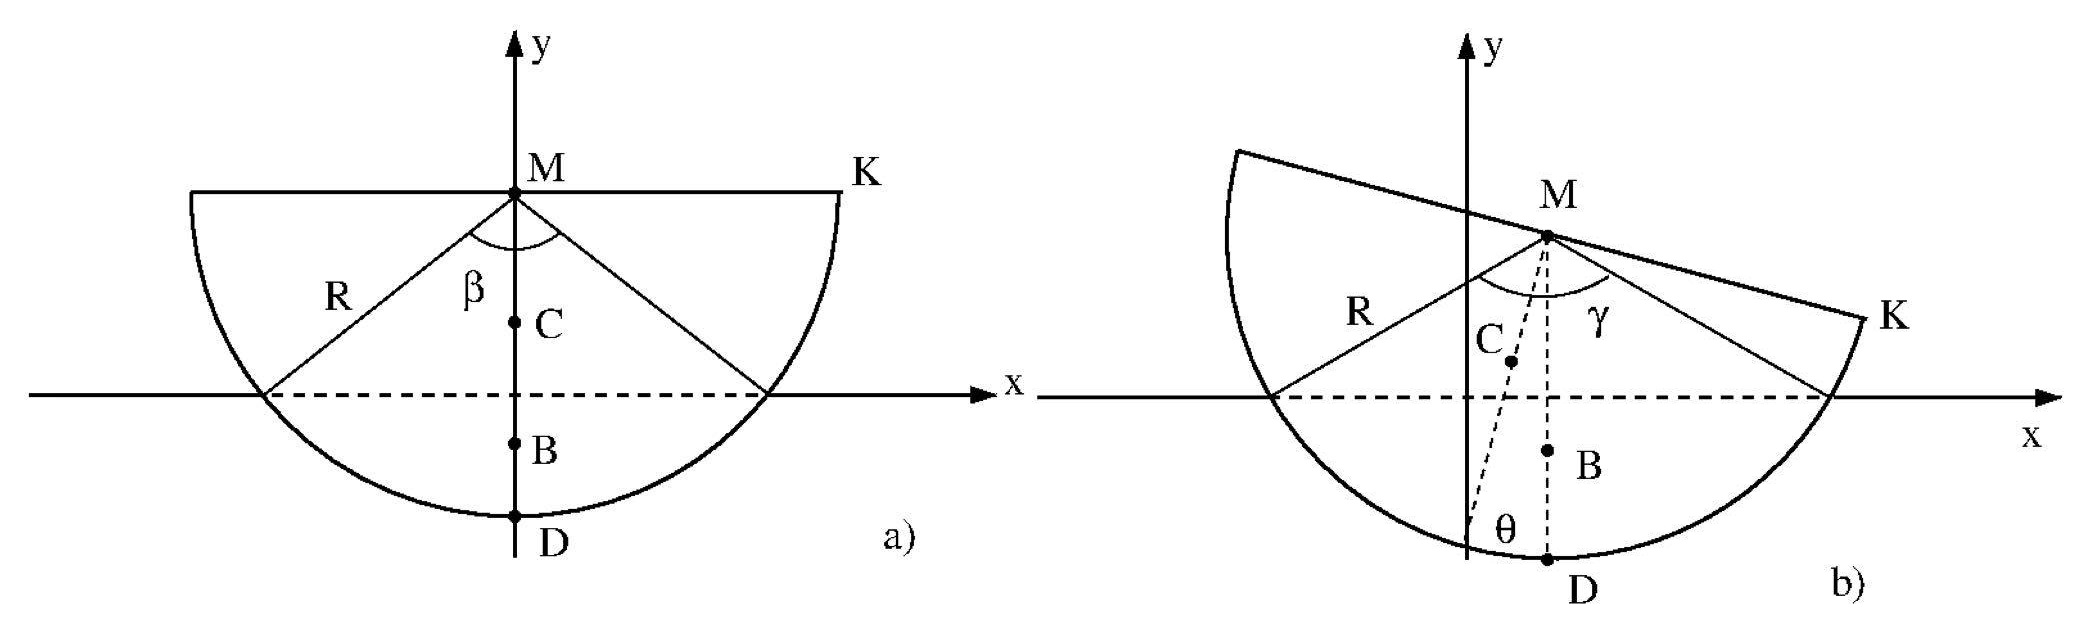
</div>


***Figure 1*** *: A sketch of our boat-model. a) The boat in equilibrium. b) The boat after displacement and rotation about the centre of mass, $C$.*




With Arkimedes law we can show that the ship, in equillibrium, displaces an area $A_0$ of water:

$$A_0 = \sigma \pi R^2 / 2 \sigma_0.$$

As the ship rotates about $C$ the amount of displaced water varies. We introduce the angle $\gamma$ shown in figure 1, and let $\gamma_{\textrm{equil}} = \beta$. Some geometry gives us the displaced-water-area $A$ in terms of $\gamma$: 

$$A = \frac{1}{2} R^2 (\gamma - \sin{\gamma}).$$

In [58]:
## Defining constants that will remain the same
sigma_0 = 1000                             # [kg/m^2] surface-density of water
sigma   = 500                              # [kg/m^2] surface-density of ship
R       = 10                               # [m]      radius of ship
A_s     = 1/2*np.pi*R**2                   # [m^2]    area of boat
A_0     = sigma*np.pi*R**2/(2*sigma_0)     # [m^2]    displaced water area in equilibrium
g       = 9.81                             # [m/s^2]  acceleration due to gravity
h_CM    = 4*R/(3*np.pi)                    # [m]      distance between C and M
m       = sigma * A_s                      # [kg]     mass of one metre boat 
I_C     = 1/2*m*R**2*(1 - 32/(9*np.pi**2)) # [kgm^2]  moment of inertia about C

In [59]:
def find_A(gamma):
    return 1/2*R**2*(gamma-np.sin(gamma))

At $\gamma=\beta$ we have $A=A_0$ giving an implicit equation for $\beta$:

$$
f(\beta) = \beta - \sin {\beta} - \pi \sigma / \sigma_0 = 0.
$$

We will solve this equation by Newtons method. As discussed in [the methods section](#newton_method) we need the derivative:

$$f'(\beta) = 1 - \cos{\beta}.$$

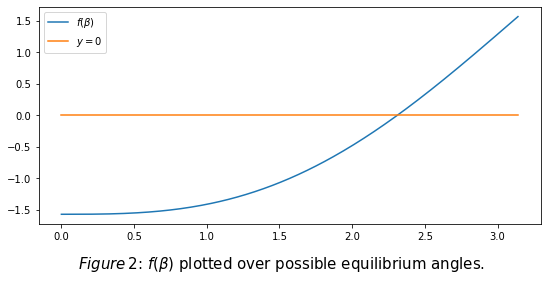

k =  0, β =  2.000000000000000, f(β) = -4.801e-01
k =  1, β =  2.339014105903838, f(β) =  4.907e-02
k =  2, β =  2.310063196572691, f(β) =  3.042e-04
k =  3, β =  2.309881467301467, f(β) =  1.220e-08
k =  4, β =  2.309881460010057, f(β) =  4.441e-16

A(β)-A₀ = 3e-14 m².


In [60]:
def find_beta_newton(b0, plot = False):
    def f(b):
        return b - np.sin(b) - np.pi*sigma/sigma_0
    def df(b):
        return 1 - np.cos(b)
    if plot:
        x = np.arange(0, np.pi, 0.01)
        fig, ax = plt.subplots(figsize=(9, 4))
        plt.plot(x, f(x))
        plt.plot(x, 0*x)
        plt.legend([r"$f(\beta)$", r"$y=0$"])
        txt = r"$Figure \, 2$: $f(\beta)$ plotted over possible equilibrium angles."
        plt.figtext(0.5, -0.03, txt, wrap=True, horizontalalignment='center', fontsize = 15)
        plt.show()
    beta = newton(f, df, b0, variable = "\u03B2")[0]
    return beta

beta = find_beta_newton(2, plot = True)

print(f"\nA(\u03B2)-A\u2080 = {round(find_A(beta)-A_0, 14)} m\u00B2.")

We know that the angle must lie between $0$ and $\pi$, since our boat clearly has to be in the water. The plot shows that there is only one root at this interval. This makes sense as there can only be one equilibrium-area. The printed table of $f(\beta)$ shows that we converge to our root. Computing $A(\beta)$ gives $A_0$ as expected. 

**Points on the ship**

An important point is the centre of the buoyant force, $B$, wich lies a distance $Y_{MB}$ below $M$:

$$Y_{MB} = R\cdot \frac{4 \sin^3{\gamma/2}}{3(\gamma - \sin{\gamma})}.$$

In [61]:
def find_yMB(gamma):
    return R*4*np.sin(gamma/2)**3 / (3*(gamma - np.sin(gamma)))

When solving the motion of the boat we will keep track of $\theta$ and $y_C$. We shall see that $\gamma$ is determined by these two values. Always knowing $\gamma$ means we can also compute $y_M$, $y_B$ and $y_D$. If we let $y=0$ at the water level, we have:

$$
\begin{align*}
y_M (\theta, y_C) &= R \cos{\gamma/2} \\
y_B (\theta, y_C) &= y_M - Y_{MB}(\gamma) \\
y_D (\theta, y_C) &= y_M - R.
\end{align*}
$$

The points $M$, $B$ and $D$ lie on the same vertical line:

$$
\begin{align*}
x_M (\theta, x_C) &= x_C + h_{CM} \sin{\theta} \\
x_B (\theta, x_C) &= x_M  \\
x_D (\theta, x_C) &= x_M.
\end{align*}
$$



In [62]:
def find_yM(gamma):
    return R*np.cos(gamma/2)
def find_yB(gamma):
    return find_yM(gamma) - find_yMB(gamma)
def find_yD(gamma):
    return find_yM(gamma) - R

def find_xMBD(theta, xC):
    return x_C + h_CM*np.sin(theta)

For a ship in equilibrium we know $\gamma = \beta$. In equilibrium $C$ lies $h_{CM}$ below $M$:

$$
\begin{align*}
y_C^0 &= y_M(\beta) - h_{CM}. \\
\end{align*}
$$

We compute the equilibrium coordinates below:

In [63]:
# 1b - definere yM0, yC0, yB0, yD0 med vannet som nullpunkt for y

yM0 = find_yM(beta)
yC0 = yM0 - h_CM
yB0 = find_yB(beta)
yD0 = find_yD(beta)

decimals = 5
print(f'yM0 = {round(yM0, decimals)} m\n')
print(f'yC0 = {round(yC0, decimals)} m\n')
print(f'yB0 = {round(yB0, decimals)} m\n')
print(f'yD0 = {round(yD0, decimals)} m')

yM0 = 4.03973 m

yC0 = -0.2044 m

yB0 = -2.45792 m

yD0 = -5.96027 m


We have seen that we need to compute $\gamma$ to find displaced water area and other important quantities. It is determined by $\theta$ and $y_C$. We have $\cos{\gamma/2}=y_M/R.$ When the boat rotates $\theta$, $y_M$ moves in a circular motion about $C$ with the radius $h_{CM}$. An additional change in $y_M$ comes from the change in $y_C$. Thus we can write:

$$ \gamma (\theta, y_C)= 2\arccos{\left( \cos{\frac{\beta}{2}} - \frac{4}{3\pi}(1-\cos{\theta}) + \frac{y_C - y_C^0}{R} \right)}.$$

In [64]:
def find_gamma(theta, yC):
    return 2*np.arccos(np.cos(beta/2) - 4/(3*np.pi)*(1-np.cos(theta)) + (yC-yC0)/R)

**Forces on the ship**




Gravity acts vertically pulling the boat down with a constant force:

$$ \vec F_G = -mg \, \hat y. $$

A net buoyant force pushes the boat upwards counteracting gravity. The net force acts in the centre of buoyancy, $B$, wich would have been the centre of mass of the displaced water. The force is proportional to our $\gamma$-dependent displaced area:

$$ \vec F_B = \sigma_0 A(\gamma) g \hat y .$$

We will model the friction between the boat and the water as proportional to the contact-area and the velocity of the boats surface. We let the force act horisontaly in the deepest point $D$. With our assumptions it is given by:

$$\vec f = -k_f R^2 \gamma \omega \, \hat x.$$

We ignore the velocity caused by a translation of the ship.

We model the wind/wave force as a horisontal harmonic force acting along the water:

$$F_w(t) = F_0 \cos{\omega_w t} \, \hat x$$


In [65]:
def F_G():
    return -m*g
def find_F_buoyant(displaced_area):
    return sigma_0*g*displaced_area
def find_F_friction(gamma, omega, k_f):
    return -k_f*R**2*gamma*omega
def find_F_waves_wind(t, F_0, omega_w):
    return F_0*np.cos(omega_w*t)

The torques about $C$ are found by multiplying the forces with their corresponding lever arms:

$$
\begin{align}
    \vec \tau_B &= -F_B h_{CM} \sin{\theta} \, \hat z\\
    \vec \tau_f &= f\left( y_C - R(\cos{\gamma/2}-1) \right) \, \hat z\\
    \vec \tau_w &= F_w y_C \,  \hat z
\end{align}
$$


In [66]:
def find_tau_buoyant(theta, F_B):
    return - F_B*h_CM*np.sin(theta)
def find_tau_friction(y_C, gamma, f):
    return f*(y_C - R*(np.cos(gamma/2) - 1))
def find_tau_waves_wind(y_C, F_w):
    return F_w*y_C

**Moving cargo**

When modelling cargo on the ship we consider the cargo to be on a stationary incline plane; we ignore effects of accelerating systems. In this case the force on the ship is given by:

$$
\begin{align*}
    F_{L, x} (\theta) &= m_L g \cos{\theta} \sin{\theta} \\
    F_{L, y} (\theta) &= - m_L g \cos^2{\theta}.
\end{align*}
$$

We introduce the cargo-coordinate $s_L$ as the distance from the metacentre $M$. Displacement to the right is considered positive. The cargo's acceleration along the deck is given by:

$$
    \ddot s_L = -g \sin \theta
$$

In [67]:
def find_F_Lx(theta):
    return m_L*g*np.cos(theta)*np.sin(theta)
def find_F_Ly(theta):
    return -m_L*g*np.cos(theta)**2

def find_a_L(theta):
    return -g*np.sin(theta)

For the angular momentum the arm from $C$ is $s_L$. Multiplication with the normal-force gives the torque:

$$
\vec \tau (\theta, s_L) = - m_L g \cos{\theta} s_L \hat z
$$

In [68]:
def find_tau_L(theta, s_L):
    return -m_L*g*np.cos(theta)*s_L

**Capsizing the ship**

We consider our ship capsized if part of the deck is below the water level. 

<div>
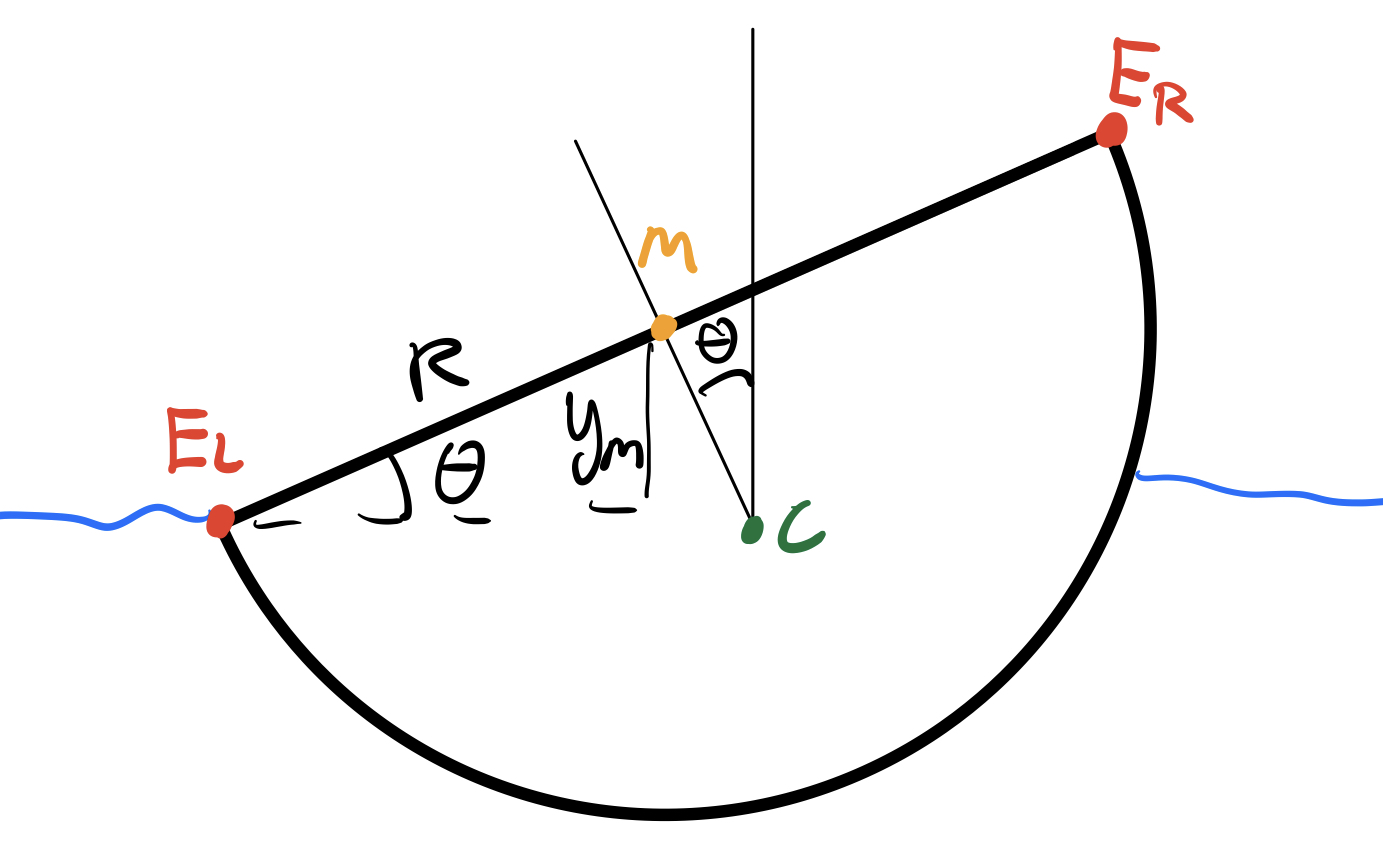
</div>

***Figure 3***: the ship at the moment it capsizes. 

To see if our boat has capsized we keep track of the y-coordinate of the left and right endpoints $E_L$ and $E_R$:

$$
\begin{align}
    y_{E_L} &= y_M - R \sin{\theta} \\
    y_{E_R} &= y_M + R \sin{\theta}
\end{align}
$$


In [69]:
def boat_has_capsized(theta, yC):
    yM = find_yM(find_gamma(theta, yC))
    yEL = yM - R*np.sin(theta)
    yER = yM + R*np.sin(theta)
    return (yEL < 0 or yER < 0)

**Equation for the system**

Throughout this project we will describe our system with the vector
$\vec{w} = \begin{bmatrix} \theta(t) & 
                           \omega(t) & 
                           x_C(t) & 
                           v_{C, x}(t) & 
                           y_C(t) & 
                           v_{C, y}(t) & 
                           s_L(t) & 
                           v_{L}(t)\end{bmatrix}^T.$ 
With this vector we can write our problem on the standard form $\frac{\textrm{d}\vec{w}}{\textrm{d}t} = \vec f(t, \vec w) $. The vector $\vec f(t, \vec w)$ contains the derivatives of the elements in $\vec w$.

$$ \frac{\textrm{d}}{\textrm{d}t} \begin{bmatrix} \theta(t) \\
                           \omega(t) \\
                           x_C(t) \\
                           v_{C, x}(t) \\
                           y_C(t) \\
                           v_{C, y}(t) \\
                           s_L(t) \\
                           v_{L}(t)\end{bmatrix} 
= \begin{bmatrix} \omega(t) \\ 
                  \Sigma\tau_C(t)/I_C \\
                  v_{C, x}(t) \\
                  \Sigma F_{C, x}(t)/m \\
                  v_{C, y}(t) \\
                  \Sigma F_{C, y}(t)/m \\
                  v_{L}(t)\\
                  \Sigma F_{L, \hat s}(t)/m\end{bmatrix}.$$

## Code for visualization <a class="anchor" id="vis"></a>

Below is a modified version of animation code that was handed out to visualise the ship. The modifications allows for saving the animation, and for $t$-arrays with constant spacing $h$ the animation will have a duration corresponding to $t_{\textrm{end}}-t_0$.


In [70]:
import matplotlib.animation

def animate_boat(t, theta, x_C, y_C, s_L=[], title="", gjerde=False, gif_name = "TEST"):
    """
    brief: Saves a gif of the ship's motion
    :param t: Array som inneholder tidsverdiene man har beregnet \vec{w} for systemet
    :param theta: Array som inneholder utslagsvinkelen til skipet
    :param x_C: Array som inneholder massesenterets x-koordinat
    :param y_C: Array som inneholder massesenterets y-koordinat
    :param s_L: Optional array som inneholder lastens posisjon relativt massesenteret
    :param title: Update from "" to add a title
    :param gjerde: Optional Boolean som forteller om vi skal tegne inn gjerder på skipet
    :return: 
    """
    h     = t[1]-t[0]
    skips = int(0.1/h) # only care about 0.1 s intervals
    t, theta, x_C, y_C, s_L = t[::skips], theta[::skips], x_C[::skips], y_C[::skips], s_L[::skips]

    fig, ax = plt.subplots()
    boat,           = ax.plot([], [], color="k", linewidth=2)
    deck,           = ax.plot([], [], color="k", linewidth=2)
    sea_surface,    = ax.plot([-R*10, R* 10], [0, 0], color='blue', linewidth=2)  # The surface
    last,           = ax.plot([], [], color="r", marker="o", markersize=10)
    CM,             = ax.plot([], [], color="g", marker="o", markersize=10)
    MS,             = ax.plot([], [], color="y", marker="o", markersize=10)
    venstre_gjerde, = ax.plot([], [], color="k", marker="|", markersize=25)
    høyre_gjerde,   = ax.plot([], [], color="k", marker="|", markersize=25)
    ax.set_xlim([-R*1.3, R* 1.3])
    ax.set_ylim([-R*1.1, R* 1.1])
    ax.set_xlabel('$x$ [m]')
    ax.set_ylabel('$y$ [m]')
    ax.set_aspect("equal")
    textbox_theory = ax.text(3, 10, '', fontsize=12, ha = 'left', va = 'top')
    plt.title(title)
                             
    # call this function for every frame in the animation
    def animate(M):
        ax.set_xlim([-R * 1.1 + np.amin(x_C), R * 1.1 + np.amax(x_C)])
        ax.set_ylim([-R*1.1, R* 1.1])
        angle_values = np.linspace(0, np.pi, 100)
        metasenter_x = x_C[M] - h_CM * np.sin(theta[M])
        metasenter_y = y_C[M] + h_CM * np.cos(theta[M])
        xs = R * np.cos(angle_values + np.pi + theta[M]) + metasenter_x
        ys = R * np.sin(angle_values + np.pi + theta[M]) + metasenter_y
        boat.set_data(xs, ys)
        deck.set_data([xs[0], xs[-1]], [ys[0], ys[-1]])
        if len(s_L) != 0:
            last.set_data(metasenter_x + s_L[M] * np.cos(theta[M]),
                          metasenter_y + s_L[M] * np.sin(theta[M]))
        CM.set_data(x_C[M], y_C[M])
        MS.set_data(metasenter_x, metasenter_y)
        if gjerde:
            venstre_gjerde.set_data([metasenter_x - R * np.cos(theta[M])], [metasenter_y - R * np.sin(theta[M])])
            høyre_gjerde.set_data([metasenter_x + R * np.cos(theta[M])], [metasenter_y + R * np.sin(theta[M])])
        
        theta_string= r'$\theta = %.2f$' % (theta[M] * 180 / np.pi) + r"$\degree$"
        time_string = '$t =  %.1f$' % (t[M])
        textbox_theory.set_text(theta_string + '\n' + time_string)

        if M % 1000 == 0:
            print(M)
        
    ani = matplotlib.animation.FuncAnimation(fig, animate, frames=len(t), repeat=False)
    frames_per_second = 1/(t[1]-t[0]) # ensure 1s on anim lasts 1s
    ani.save(f'animations/{gif_name}.gif', fps = frames_per_second)

Below are two functions for creating figures that automatically track figure-numbers. 

In [71]:
figure_count = 3 # To keep track of figure numbers
def plot_function(x_vals_list, y_vals_list, title = "",
    xlabel = r"$t$ [s]", ylabel = r"$\theta$ [rad]", labels = False,
    fig_text = False, fig_text_size = 15, fig_text_y = -0.04,
    title_size = 15, label_size = 15, fig_size = (9, 5), 
    loc = "upper right", file_title = False, 
    linestyles = False, set_xlim = False, set_ylim = False):
    """
    brief: 
    :param x_vals_list: 
    
    :return:
    """
    fig, ax = plt.subplots(figsize=fig_size)
    for i in range(len(y_vals_list)):
        if linestyles and len(linestyles) >= i+1:
            plt.plot(x_vals_list[i], y_vals_list[i], linestyles[i])
        else:
            plt.plot(x_vals_list[i], y_vals_list[i])
    plt.title(title, size = title_size)
    plt.xlabel(xlabel, size = label_size)
    plt.ylabel(ylabel, size = label_size)
    if labels:
        plt.legend(labels, loc=loc, prop={'size': label_size-2})
    if fig_text:
        global figure_count
        figure_count += 1
        txt = f"$Figure$ ${figure_count}$: " + fig_text
        plt.figtext(0.5, fig_text_y, txt, wrap=True, horizontalalignment='center', fontsize = fig_text_size)
    if set_xlim:
        ax.set_xlim(set_xlim)
    if set_ylim:
        ax.set_ylim(set_ylim)
    if file_title:
        fig.savefig(f'figures/{file_title}.png')
    plt.show()
    
def plot_function_dual(x_vals_list, y_vals_list, linestyles, titles = ["", ""],
    xlabels = [r"$t$ [s]", r"$t$ [s]"], ylabels = [r"$\theta$ [rad]", r"$\theta$ [rad]"],
    labels = [False, False], fig_text = False, fig_text_size = 15, fig_text_y = -0.04, title_size = 15, 
    label_size = 15, fig_size = (15, 5), loc = ["upper right", "upper right"], file_title = False):
    """
    brief: 
    :param x_vals_list: 
    
    :return:
    """
    fig, axs = plt.subplots(1, 2, figsize=fig_size)
    for i in range(len(axs)):
        for j in range(len(x_vals_list[i])):
            axs[i].plot(x_vals_list[i][j], y_vals_list[i][j], linestyles[i][j])
        axs[i].set_title(titles[i], size = title_size)
        if labels[i]:
            axs[i].legend(labels[i], loc=loc[i], prop={'size': label_size-2})
        axs[i].set_xlabel(xlabels[i], size = label_size)
        axs[i].set_ylabel(ylabels[i], size = label_size)

    if fig_text:
        global figure_count
        figure_count += 1
        txt = f"$Figure$ ${figure_count}$: " + fig_text
        plt.figtext(0.5, fig_text_y, txt, wrap=True, horizontalalignment='center', fontsize = fig_text_size)
    if file_title:
        fig.savefig(f'figures/{file_title}.png')
    plt.show()

## Harmonic oscillator with constant $A$ <a class="anchor" id="constA"></a>

**System equation when assuming constant water-displacement**

We begin our modelling of the boat with a very simple model. We assume that the centre of mass stays fixed and ignore all forces but the bouyancy. $C$ remains fixed by pretending that the displaced area $A$ is constant and equal to $A_0$.Thus $\Sigma F_y = F_B - F_G = 0$. Only the torque from the bouyancy, $\tau_B$, contributes to motion. Our system is described by:

$$
I_C \alpha(t) = \tau_B(t).
$$

Introdusing the angular velocity $\omega$ we can rewrite the second order ODE to a system of first order ODE's:

$$
\begin{align*}
\frac{\textrm{d}\theta}{\textrm{d}t} &= \omega \\
\frac{\textrm{d}\omega}{\textrm{d}t} &= \alpha = \tau_B(t)/I_C.
\end{align*}
$$

With the initial conditions $v_{C, x} = v_{C, y} = x_C = 0$ and $y_C = y_C^0$ all other variables remain constant, and our system can be written:

$$ \frac{\textrm{d}}{\textrm{d}t} \begin{bmatrix} \theta(t) \\
                           \omega(t) \\
                           x_C(t) \\
                           v_{C, x}(t) \\
                           y_C(t) \\
                           v_{C, y}(t) \\
                           s_L(t) \\
                           v_{L}(t)\end{bmatrix} 
= \begin{bmatrix} \omega(t) \\ 
                  \tau_B(t)/I_C \\
                  0 \\
                  0 \\
                  0 \\
                  0 \\
                  0 \\
                  0 \end{bmatrix}.$$

In [72]:
def f_harmonic_oscillator(t, w):
    """
    brief: the derivative of the vector w = [theta, omega]
           only including the harmonic restorative buoyant force
    :param theta: current angle
    :param omega: current angular velocity
    :return: the derivative
    """
    tau_B = find_tau_buoyant(w[0], find_F_buoyant(find_A(beta)))
    return np.array([w[1], tau_B/I_C, 0, 0, 0, 0, 0, 0])

**Eulers method and the ODE-solver**

Below we implement Eulers method discussed in ***REF***. When implementing the ODE-solver we include the possibility that the boat capsizes right away using our function from ***REF***. 

In [73]:
def euler_method(f, t, w, h):
    """
    brief: One step of Eulers method
    :param f: the function f(t, w)
    :param t: current t-value
    :param w: current w-value
    :param h: stepsize
    :return: the next value for tn and wn
    """
    t_next = t + h
    w_next = w + h*f(t, w)
    return t_next, w_next

def ode_solver(f, t0, t_end, w0, h0, method=euler_method):
    """
    brief: Solves the ode w' = f(t, w) with method of choice
    :param f: the function f(x)
    :param t0: initial t-value
    :param t_end: the final t-value
    :param w0: initial w-value
    :param h: stepsize
    :param method: the method used in each step
    :return: the next value for tn and wn
    """
    #Create arrays to store values
    t_num = np.array([t0])    
    w_num = np.array([w0])    

    # Values that are updated for each iteration
    tn = t0                
    wn = w0 
    h  = h0 #updated in last step
    
    # Main loop
    capsized = boat_has_capsized(wn[0], wn[2])
    while tn < t_end - 1.e-10: # Buffer for truncation errors        
    
        if not capsized:
            capsized = boat_has_capsized(wn[0], wn[4])

        if t_end - tn < h:
            h = t_end - tn
        
        if capsized:
            tn += h
            wn = np.array([np.pi/2 * np.sign(wn[0]), 0, wn[2], 0, max(-R, wn[4]-0.2), 0, 0, 0])
        else:
            tn, wn = method(f, tn, wn, h) # Do last step             

        # Add values to array
        t_num = np.append(t_num,tn)
        w_num = np.concatenate((w_num, np.array([wn])))
      
    return t_num, np.transpose(w_num)

**Finding appropriate stepsize with Eulers method**

Now that we have implementet our solver it is time to test it with different stepsizes $h$. We start the ship at $\theta_0 = 20^\circ$ and $\omega_0 = 0$. We start the iterations at $t=0\textrm{ s}$ and let it run for $20 \textrm{s}$.

In [74]:
# 1d) 

t0, t_end = 0, 20
# w0 = np.array([20*np.pi/180, 0, 0, 0, yC0, 0, 0, 0]) #[theta0, omega0, x0, vx0, y0, vy0, s0, vs0]
# times, thetas = [], []
# h_list = [0.01, 0.001, 0.0001]
# for h in h_list:
#     t_num, w_num = ode_solver(f_harmonic_oscillator, t0, t_end, w0, h, method=euler_method)
#     times.append(t_num)
#     thetas.append(w_num[0])
# #     animate_boat(t_num, w_num[0], w_num[2], w_num[4], 
# #                  title = f"$h$ = {h}", gif_name = f"HO_h={h}")  

# plot_function(times, thetas, fig_text = r"$\theta(t)$ for our simplest model, solved at different stepsizes $h$ with Eulers method.", 
#     fig_text_y = -0.1, linestyles = ['r', 'b', 'g'], labels = [f"$h$ = {h}" for h in h_list], loc = "upper left", set_ylim = [-0.4, 0.7])

The plot clearly shows that $h=0.01$ is not sufficient; the boat capsizes. With $h=0.001$ and $h=0.0001$ the difference in amplitudes is barely visible. We conclude that $0.001$ is a good stepsize; the error is barely notable and the runtime is good. 

<a class="anchor" id="anim1"></a>

| | |
:-------------------------:|:-------------------------:
![](animations/HO_h=0.01.gif) | ![](animations/HO_h=0.001.gif)

***Animation 1***: Boat capsizing due to insufficient stepsize.*


**Small angle approximation**

We take some time to test the accuracy of the small angle approximation $\sin \theta \approx \theta$. The torque from the bouyant force becomes:

$$
\vec \tau_{B, SA} = -F_B h_{CM} \theta \hat z\\
$$

We define this force and the corresponding system-equation below:

In [75]:
#1e
def find_tau_buoyant_small_angle(theta, F_B):
    return - F_B*h_CM*theta

def f_harmonic_approxilator(t, w):
    """
    brief: the derivative of w only including the harmonic restorative 
           buoyant force, now with small angle approximation
    :param t: current time
    :param w: 8D array with current theta, omega, x, vx, y, vy, s, vs
    :return: 8D array with derivatives of the above parametres
    """
    tau_B = find_tau_buoyant_small_angle(w[0], find_F_buoyant(find_A(beta)))
    return np.array([w[1], tau_B/I_C, 0, 0, 0, 0, 0, 0])

To test its accuracy we run the same simulation as before with the starting angles $1°$ and $20°$:

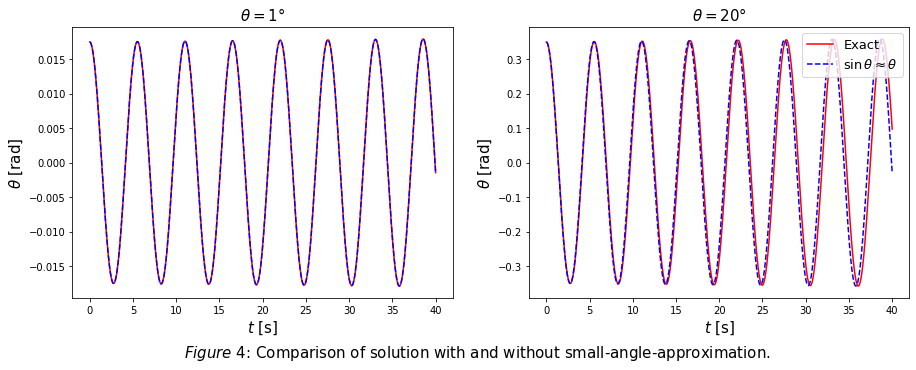

In [76]:
t_end = 40
h = 0.001
Theta_deg = [1, 20]
Theta = [thet*np.pi/180 for thet in Theta_deg]
x_vals_list = []
y_vals_list = []
for theta0 in Theta:
    w0 = [theta0, 0, yC0, 0, 0, 0, 0, 0]
    
    t_exact, w_exact   = ode_solver(f_harmonic_oscillator, t0, t_end, w0, h, method=euler_method)
    t_approx, w_approx = ode_solver(f_harmonic_approxilator, t0, t_end, w0, h, method=euler_method)   
    
    x_vals_list.append([t_exact, t_approx])
    y_vals_list.append([w_exact[0], w_approx[0]])
    
plot_function_dual(x_vals_list, y_vals_list, [['r', 'b--'], ['r', 'b--']], 
    titles = [r"$\theta=$" + f"{Theta_deg[0]}\u00B0", r"$\theta=$" + f"{Theta_deg[1]}\u00B0"], 
    fig_text = "Comparison of solution with and without small-angle-approximation.", 
    labels = [False, ["Exact", r"$\sin{\theta}\approx \theta$"]])

The figure shows that there is no significant difference at $\theta=1°$. At $20°$ the period is too small. This is because $\theta > \sin\theta$. Thus the restoriative force in the harmonic oscillator is overestimated using the approximation.

**The classic Runge Kutta method and global error**

We now implement the RK4 method discussed in ***REF***:

In [77]:
# 1f

def RK4_method(f, t, w, h):
    """
    brief: One step of RK4 method
    :param f: the function f(t, w)
    :param t: current t-value
    :param w: current w-value
    :param h: stepsize
    :return: the next value for tn and wn
    """
    k1 = f(t, w)
    k2 = f(t + h/2, w + h*k1/2)
    k3 = f(t + h/2, w + h*k2/2)
    k4 = f(t + h, w + h*k3)    
    
    t_next = t + h
    w_next = w + h/6*(k1 + 2*k2 + 2*k3 + k4)
    return t_next, w_next

**Analytic solution with the small angle approximation**

With the small angle approximation $\sin{\theta}\approx\theta$ our equation became:

$$
\begin{align*}
I_C\ddot{\theta} &= - F_B h_{CM} {\theta} = 0\\
\ddot{\theta} + \frac{F_B h_{CM}}{I_C} {\theta} &= 0.\\
\end{align*}
$$

With the initial conditions $\tilde\theta(0)=\theta_0, \, \tilde\omega(0)=0$ it has the analytic solution:

$$
\tilde{\theta} (t) = \theta_0 cos\left(\omega_0 t\right), \,\,\,\, \omega_0 = \sqrt{\frac{F_B h_{CM}}{I_C}}.
$$

We can use this to investigate how the global error $E_G$ depends on our stepsize $h$. We begin by defining the analytic solution:

In [78]:
# 1g
def find_omega_0(F_B):
    return np.sqrt(F_B*h_CM/I_C)

def analytic_harmonic_oscillator(time_array, theta0):
    F_B = find_F_buoyant(find_A(beta))
    omega_HO = find_omega_0(F_B)
    return theta0*np.cos(omega_HO*time_array)

**Error and order of methods**

We now iterate over different stepsizes $h$, and plot $\log{E_G}$ as a function of $\log{h}$.

In [79]:
# #1h

# N = 97
# h_array = np.linspace(1e-2, 5e-3, N)
# global_error_euler = np.zeros(N)
# global_error_RK4   = np.zeros(N)
# w0 = [0.01, 0, 0, 0, yC0, 0, 0, 0] # [theta0, omega0, x0, vx0, y0, vy0, s0, vs0]

# for i in tqdm(range(len(h_array))):
#     h = h_array[i]
#     theta_anal  = analytic_harmonic_oscillator(t_end, w0[0])
#     o, w_euler = ode_solver(f_harmonic_approxilator, t0, t_end, w0, h, method=euler_method)
#     o, w_RK4   = ode_solver(f_harmonic_approxilator, t0, t_end, w0, h, method=RK4_method)
#     global_error_euler[i] = np.abs(theta_anal - w_euler[0][-1])
#     global_error_RK4[i]   = np.abs(theta_anal - w_RK4[0][-1])

# log_euler = np.log10(global_error_euler)
# log_RK4   = np.log10(global_error_RK4)
# log_h     = np.log10(h_array)

# x_vals_list = [[log_h,     log_h],     [log_h,   log_h]]
# y_vals_list = [[log_euler, log_h - 2.2], [log_RK4, 4*log_h-1.7]]
# fig_txt = "Logarithm of global error VS logarithm of stepsize for our methods."

# plot_function_dual(x_vals_list, y_vals_list, [['r', 'b--'], ['r', 'b--']], 
#     labels = [["Euler", "slope = 1"], ["RK4", "slope = 4"]], xlabels = [r'log $h$', r'log $h$'],
#     ylabels=[r'log $E_G$', r'log $E_G$'], fig_text = fig_txt, loc = ["upper left", "upper left"],
#     title_size=25)

In [80]:
# from scipy.optimize import curve_fit

# def linear_regression(xvals, yvals):
#     def func(x, a, b):
#         return a*x+b

#     popt, pcov = curve_fit(func, xvals, yvals)
#     a, b = popt
#     plt.figure()
#     plt.plot(xvals, func(xvals, *popt))
#     plt.title('ax + b med: a=%.3f, b=%.3f' % (a, b))
    
# linear_regression(log_h, log_RK4)
# linear_regression(log_h, log_euler)

**VI MÅ SE PÅ ØVINGA DER MAN FINNER ORDEN GRAFISK...**

As discussed in ***REF METHOD SECTION*** the global error is proportional to $h^{\textrm{order}}$. Plotting $\log\textrm{(error)}$ vs $\log h$ should give a straight line with a slope equal to the order of the method. 

***MER***

***MER***

??



## Varying displaced-water-area <a class="anchor" id="water"></a>

**Varying displaced-water-area**

We will now include the effect of changing the area of displaced water. The boyant force is no longer constant and equal to $F_G$, so $y_C$ is subject to change. Our system becomes

$$ \frac{\textrm{d}}{\textrm{d}t} \begin{bmatrix} \theta(t) \\
                           \omega(t) \\
                           x_C(t) \\
                           v_{C, x}(t) \\
                           y_C(t) \\
                           v_{C, y}(t) \\
                           s_L(t) \\
                           v_{L}(t)\end{bmatrix} 
= \begin{bmatrix} \omega(t) \\ 
                  \tau_B(t)/I_C \\
                  0 \\
                  0 \\
                  v_{C, y}(t) \\
                  (F_B(t)-F_G)/m \\
                  0\\
                  0\end{bmatrix}.$$


In [81]:
# 2a

def f_bouncing(t, w):
    """
    brief: the derivative of the vector w, now accounting for variations in displaced waterar
    :param t: current time
    :param w: 8D array with current theta, omega, x, vx, y, vy, s, vs
    :return: 8D array with derivatives of the above parametres
    """
    gamma = find_gamma(w[0], w[4])
    A     = find_A(gamma)
    F_B   = find_F_buoyant(A)
    tau_B = find_tau_buoyant(w[0], F_B)
    
    dtheta = w [1]
    domega = tau_B/I_C
    dy_C   = w [5]
    dv_Cy  = (F_B + F_G())/m
    return np.array([dtheta, domega, 0, 0, dy_C, dv_Cy, 0, 0])

In [82]:
# 2b

t0 = 0
t_end = 20
h = 0.001
w0 = [20*np.pi/180, 0, 0, 0, yC0, 0, 0, 0]

t_vals_HO, w_vals_HO = ode_solver(f_harmonic_oscillator, t0, t_end, w0, h, method=RK4_method)
t_vals_bounce, w_vals_bounce = ode_solver(f_bouncing, t0, t_end, w0, h, method=RK4_method)

# vals = solve_ivp(f_harmonic_oscillator, (t0, t_end), w0, max_step=1.0e-2)
# t_vals_HO, w_vals_HO = vals.t, vals.y
# vals = solve_ivp(f_bouncing, (t0, t_end), w0, max_step=1.0e-2)
# t_vals_bounce, w_vals_bounce = vals.t, vals.y

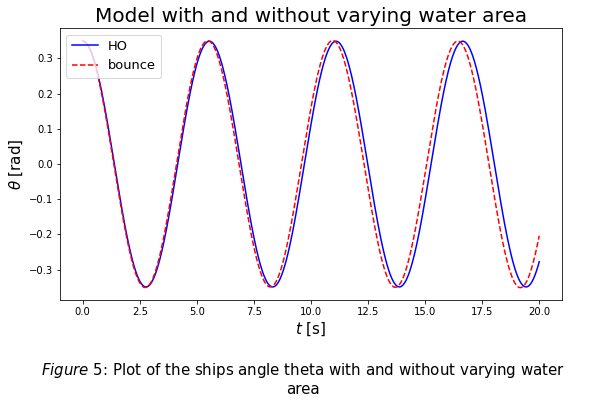

In [83]:
plot_function([t_vals_HO, t_vals_bounce], [w_vals_HO[0], w_vals_bounce[0]], 
              title = f"Model with and without varying water area",
              fig_text = "Plot of the ships angle theta with and without varying water area", fig_text_y=-0.13, linestyles = ['b', 'r--'], title_size=20,
              labels = ["HO", "bounce"], loc = "upper left")

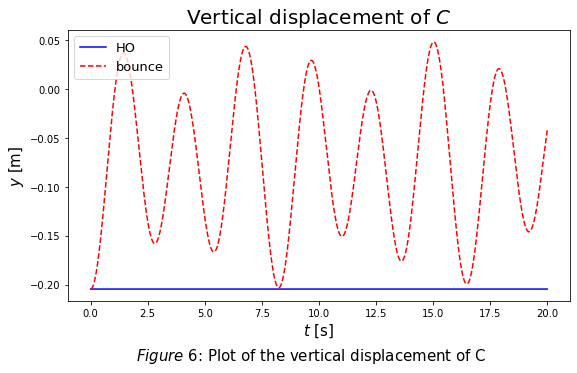

In [84]:
plot_function([t_vals_HO, t_vals_bounce], [w_vals_HO[4], w_vals_bounce[4]], 
              title = r"Vertical displacement of $C$",
              fig_text = "Plot of the vertical displacement of C", linestyles = ['b', 'r--'], title_size=20,
              ylabel = r"$y$ [m]", labels = ["HO", "bounce"], loc = "upper left")

**WHY is vary A behind?? explain, y variation +++** 
y is deep when angle big. Big response ... Faster return... also lower amplitude...

From figure 5 we can see that the frequency of the oscillations is higher when we take into account the varying area of displaced water. This is because the area of dissplaced water increases as the ship dips to one side, meaning the boyant force and consequently the tourque it generates will be greater than if the displaced water was constant. The increase in torque causes the ship to decelerate faster when shifting to one side, and accelerate faster when returning, which increases the frequency of the oscillations. By examining figure 5 and 6 one can notice that $y_C$ is at its lowest when the absolute value of $\theta$ is at its maximum. Because of this the variation in displaced water should slightly increase the chances of capsizing, eventhough it does not increase the maximum value of $\theta$. Overall the effects of the variation in displaced water does not seem to be substantial, considering the vertical dissplacement of $y_C$ and the cahnge in frequency are both quite minor.    

In [85]:
# animate_boat(t_vals_HO, w_vals_HO[0], w_vals_HO[2], w_vals_HO[4], title = f"Constant $A$", gif_name = f"constant_A")
# animate_boat(t_vals_bounce, w_vals_bounce[0], w_vals_bounce[2], w_vals_bounce[4], title = f"Varying $A$", gif_name = f"varying_A")

<a class="anchor" id="anim1"></a>

| | |
:-------------------------:|:-------------------------:
![](animations/constant_A.gif) | ![](animations/varying_A.gif)

***Animation 2***: Comparing the motion of the ship with and without accounting for the changing displaced-water-area.*


**Lowest $\omega_0$ that results in capsizing**

Figure ***REF*** shows how the displaced area is always smaller than $A_0$ when we let it vary. The torque is lower, resulting in less dampening. If we let the boat start horisontally with an angular velocity $\omega_0$, we therefore expect the ship to capsize easier when we let $A$ vary. We test this hypothesis below. 

In [86]:
# 2c - lowest omega_0 that gives capsize

tol = 0.001
def find_lowest_omega_0(function):
    t0, t_end = 0, 5 # One period is less than 5. If the ship hasn't capsized after T, it only capsizes later if h is too small
    theta_end = 0
    accuracy  = 0.1
    omega_0   = 0
    while accuracy >= tol:
        theta_end = ode_solver(function, t0, t_end, [0, omega_0, 0, 0, 0, 0, 0, 0], h, method = RK4_method)[1][0][-1]
        if abs(theta_end) > np.pi/2-0.001: # the boat capsized
            omega_0  -= accuracy
            accuracy /= 10
        else:
            omega_0 += accuracy
    return omega_0 + accuracy*10 # if not + accuracy we find the highest omega_0 where we don't capsize

print(f"The lowest \u03C9\u2080 resulting in capsizing:")
print(f"   -constant A:   {round(find_lowest_omega_0(f_harmonic_oscillator), int(-np.log10(tol)))} rad/s.")
print(f"   -varying A:    {round(find_lowest_omega_0(f_bouncing), int(-np.log10(tol)))} rad/s.")

The lowest ω₀ resulting in capsizing:
   -constant A:   0.455 rad/s.
   -varying A:    0.437 rad/s.


As expected the lowest $\omega_0$ that gives capsizing is lower when varying $A$.

## Boat with cargo <a class="anchor" id="cargo"></a>

**Equilibrium with cargo**

With added cargo the ship will lie deeper in the water. To avoid unnecessary bouncing we want our ship to have the correct initial $y_C$. When adding cargo to the ship we show using Arkimedes, that the displaced water in equilibrium is given by:

$$A_0 = \frac{\sigma \pi R^2 + 2m_L}{2 \sigma_0.}$$

Once again we use that:

$$A = \frac{1}{2} R^2 (\gamma - \sin{\gamma}).$$

At $\gamma=\beta$ we have $A=A_0$ giving an implicit equation for $\beta$:

$$
\begin{align}
f(\beta) &= \beta - \sin {\beta} - \pi \sigma / \sigma_0 - \frac{2m_L}{R^2\sigma_0} = 0.
\end{align}
$$

We solve this equation by Newtons method. Therefore we need the derivate:

$$f'(\beta) = 1 - \cos{\beta}.$$

When we have our new value for $\beta$ we can use this to calculate $y_C^0$ in the same manner as before.

In [87]:
def find_equilibrium_with_cargo(m_L, b0):
    def f(b):
        return b - np.sin(b) - np.pi*sigma/sigma_0 - 2*m_L/(sigma_0*R**2)
    def df(b):
        return 1-np.cos(b)

    beta_cargo = newton(f, df, b0, variable = "\u03B2", table = False)[0]
    
    yM0_cargo = find_yM(beta_cargo)
    yC0_cargo = yM0_cargo - h_CM
    
    return beta_cargo, yC0_cargo

beta_0001m, yC0_0001m = find_equilibrium_with_cargo(0.001*m, 2)
beta_008m, yC0_008m = find_equilibrium_with_cargo(0.08*m, 2)

print(f"yC\u2080(mL = 0)      = {round(yC0, 3)}")
print(f"yC\u2080(mL = 0.001m) = {round(yC0_0001m, 3)}")
print(f"yC\u2080(mL = 0.08m)  = {round(yC0_008m, 3)}")

yC₀(mL = 0)      = -0.204
yC₀(mL = 0.001m) = -0.209
yC₀(mL = 0.08m)  = -0.545


For the heavy cargo we se that neglecting the change in $y_C^0$ could have caused a lot of bouncing.

**Equation for a ship with cargo**

Before presenting the equation for the ship with cargo we justify ignoring effects of accelerating frames of reference by looking at the following plot:

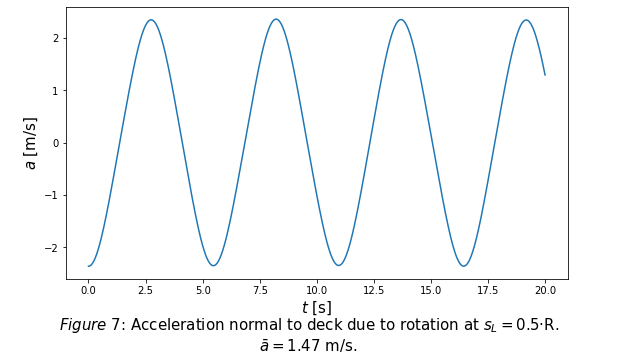

In [88]:
s_L_factor = 1/2
acceleration = 1/2*R*np.gradient(w_vals_bounce[1])/h # s_L * alpha(t)

avg = round(np.average(abs(acceleration)), 2)
text = f"Acceleration normal to deck due to rotation at $s_L=${s_L_factor}\u00B7R. "+r"$\bar{a}=$" + str(round(avg, 2)) + " m/s."

plot_function([t_vals_bounce], [acceleration], fig_text = text, ylabel = r"$a$ [m/s]", fig_text_y = -0.07)

The plot shows that the acceleration due to the ships rotation is quite small $R/2$ away from $M$. At the edge the acceleration doubles, so for cargo that spends a lot of time close to the edges our approximation becomes less valid. 

Adding the cargo our system becomes:

$$ \frac{\textrm{d}}{\textrm{d}t} \begin{bmatrix} \theta(t) \\
                           \omega(t) \\
                           x_C(t) \\
                           v_{C, x}(t) \\
                           y_C(t) \\
                           v_{C, y}(t) \\
                           s_L(t) \\
                           v_{L}(t)\end{bmatrix} 
= \begin{bmatrix} \omega(t) \\ 
                  (\tau_B(t)+\tau_L(t))/I_C \\
                  v_{C, x}(t) \\
                  F_{L, x}(t) / m \\
                  v_{C, y}(t) \\
                  (F_B(t)+F_G+F_{L, y}(t))/m \\
                  v_{L}(t)\\
                  -g\sin{\theta(t)}\end{bmatrix}.
$$

**Ship without fences**

We begin by allowing the cargo to fall of the ship. When this happens $m_L$ is set to zero so that it will no longer affect the motion of the ship. 
                  

In [89]:
def f_cargo_without_fence(t, w):
    """
    brief: the derivative of the vector w, now including cargo that can fall off
    :param t: current time
    :param w: 8D array with current theta, omega, x, vx, y, vy, s, vs
    :return: 8D array with derivatives of the above parametres
    """
    gamma = find_gamma(w[0], w[4])
    A     = find_A(gamma)
    F_B   = find_F_buoyant(A)
    F_Ly  = find_F_Ly(w[0])
    F_Lx  = find_F_Lx(w[0])
    tau_B = find_tau_buoyant(w[0], F_B)
    tau_L = find_tau_L (w[0], w[6])
    
    global m_L
    if abs(w[6]) > R:
        m_L = 0
        dv_L = 0
    else:
        dv_L = -g*np.sin(w[0])
        
    dtheta = w[1]
    domega = (tau_B+tau_L)/I_C
    dx_C   = w[3]
    dv_Cx  = F_Lx/m
    dy_C   = w[5]
    dv_Cy  = (F_B + F_G() + F_Ly)/m
    ds_L   = w[7]     
    
    return np.array([dtheta, domega, dx_C, dv_Cx, dy_C, dv_Cy, ds_L , dv_L])

In [90]:
def find_cargo_offboard(s_L): 
    """
    #returns: index of which cargo falls off board, zero if cargo stays on board the whole time
    
    """
    for i in range(len(s_L)):
        if abs(s_L[i]) > R:
            return i
    return -1

t0, t_end = 0, 40
h = 0.01
w0 = [0, 0.2, 0, 0, yC0, 0, 3, 0]

times, thetas, s_Ls = [], [], []

m_L_factor_list = [0.001, 0.08]
initial_yC      = [yC0_0001m, yC0_008m]
for i in range(len(m_L_factor_list)):
    m_L = m_L_factor_list[i] * m
    w0[4] = initial_yC[i] # start at equilibrium height
    
    t_vals, w_vals = ode_solver(f_cargo_without_fence, t0, t_end, w0, h, method=RK4_method)
    cargo_offboard = find_cargo_offboard(w_vals[6])
    
    times.append([t_vals[0:cargo_offboard], t_vals[cargo_offboard::]])
    thetas.append([w_vals[0][0:cargo_offboard], w_vals[0][cargo_offboard::]])
    s_Ls.append([w_vals[6][0:cargo_offboard]])
    
#     animate_boat(t_vals, w_vals[0], w_vals[2], w_vals[4], w_vals[6], 
#     title = r"$m_L=$ " + f"{m_L_factor_list[i]} $m$", gif_name = f"no_fence_mL={m_L_factor_list[i]}m")  

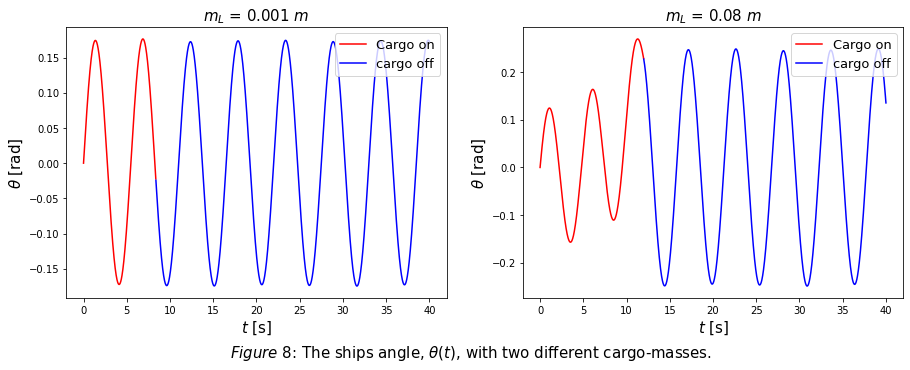

In [91]:
plot_function_dual(times, thetas, [['r', 'b'], ['r', 'b']], titles = 
                   [f"$m_L$ = {m_L_factor_list[0]} $m$", f"$m_L$ = {m_L_factor_list[1]} $m$"""], 
                   labels = [["Cargo on", "cargo off"], ["Cargo on", "cargo off"]], 
                   fig_text = r"The ships angle, $\theta(t)$, with two different cargo-masses.", 
                   loc = ["upper right", "upper right"], title_size=15)    

Our first plot shows that the light cargo has no visible effect on the ships rotation. With the heavy cargo the amplitudes start out lower. This is because we start out with the cargo to the right of $M$. At this position it gives a torque opposing the initial anti-clockwise angular velocity. Due to the low initial amplitudes the heavy cargo stays on the ship slightly longer as it is not subject to the same accelerations as the light cargo. This difference is even more evident from our next plot. 

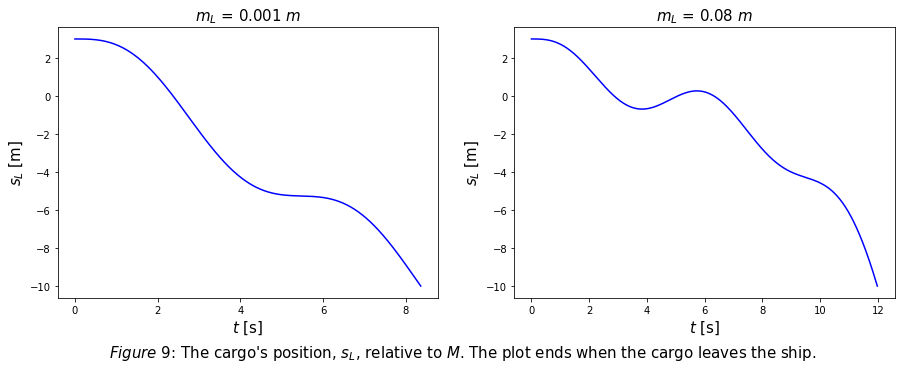

In [92]:
plot_function_dual([[times[0][0]], [times[1][0]]], s_Ls, [['b', 'tab:blue'], ['b', 'tab:blue']], 
                   [f"$m_L$ = {m_L_factor_list[0]} $m$", f"$m_L$ = {m_L_factor_list[1]} $m$"""], 
                   ylabels = [f"$s_L$ [m]", f"$s_L$ [m]"], title_size=15, 
                   fig_text = r"The cargo's position, $s_L$, relative to $M$. The plot ends when the cargo leaves the ship.")    

The plot above shows how the early steepness of the deck with light cargo gives it a speed to the left that never changes direction. With the heavy cargo its velocity changes direction before it gets to big and the cargo falls off. 

<a class="anchor" id="anim1"></a>

| | |
:-------------------------:|:-------------------------:
![](animations/no_fence_mL=0.001m.gif) | ![](animations/no_fence_mL=0.08m.gif)

***Animation 3***: The motion of fenceless boats with different cargo-masses. The cargo is represented as a red point-mass.*

Turning our attention to the animation we observe something interesting; with the heavy cargo the ship travels a significant distance to the right after the cargo drops off. The explanation lies in the conservation of momentum. The system starts out with $p_{x, tot} = 0$. Since there are no external forces in the $x$-direction this can never change. In both the animation the cargo is thrown to the left at approximatelly the same speed. To conserve momentum the ship sails to the right with an equal but opposite momentum. This momentum is most visible in the right plot as the heavy cargo has a momentum about $80$ times that of the light cargo. 

We take a closer look at the momentum of the heavy-cargo-syste, by creating another plot.

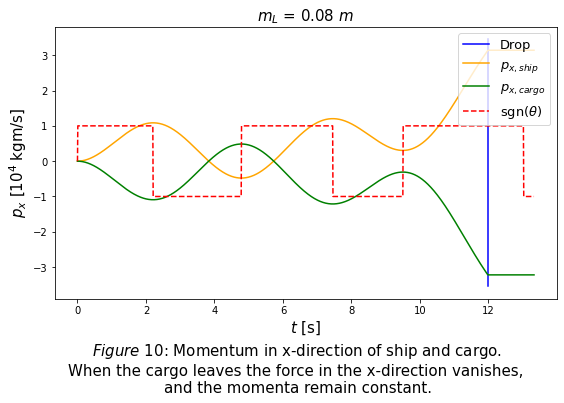

In [93]:
px_ship  = m*w_vals[3] * 10**-4
px_cargo = m_L_factor_list[1]*m*w_vals[7]  * 10**-4

vline_x = [t_vals[cargo_offboard], t_vals[cargo_offboard]]
vline_y = [1.1*min(min(px_cargo), min(px_ship)), 1.1*max(max(px_cargo), max(px_ship))]

plot_function([vline_x, np.array_split(t_vals, 3)[0],  np.array_split(t_vals, 3)[0], np.array_split(t_vals, 3)[0]],
              [vline_y, np.array_split(px_ship, 3)[0], np.array_split(px_cargo, 3)[0], np.array_split(np.sign(w_vals[0]), 3)[0]],
              title = f"$m_L$ = {m_L_factor_list[1]} $m$", labels = ["Drop", r"$p_{x, ship}$", r"$p_{x, cargo}$", r"sgn($\theta$)"], 
              fig_text = f"Momentum in x-direction of ship and cargo. \nWhen the cargo leaves the force in the x-direction vanishes, \nand the momenta remain constant.", 
              fig_text_y=-0.13, ylabel = r"$p_x$ [$10^4$ kgm/s]", title_size=15, linestyles = ['blue', 'orange', 'g', 'r--'])

The momentum-plot above clearly shows how the momentum allways sums to zero. The dotted red line shows that increasing $p_{x, \textrm{ship}}$ occurs when the angle is positive and vica versa, as expected. 

**Ship with fences**

\
\
\
\
\
\
\
\

We ignore the change in momentum from the cargo hitting the fences, and the fact that while the cargo is at the fence the force on the ship changes (the normal force is only up **?????????????** )

\
\
Conserving px
\
\
\
py
\
\
\
\
\
L????
\
\
\


In [94]:
def f_cargo_with_fence(t, w):
    """
    brief: the derivative of the vector w, now including cargo that is stopped at edges
    :param t: current time
    :param w: 8D array with current theta, omega, x, vx, y, vy, s, vs
    :return: 8D array with derivatives of the above parametres
    """
    gamma = find_gamma(w[0], w[4])
    A     = find_A(gamma)
    F_B   = find_F_buoyant(A)
    F_Ly  = find_F_Ly(w[0])
    F_Lx  = find_F_Lx(w[0])
    tau_B = find_tau_buoyant(w[0], F_B)
    tau_L = find_tau_L (w[0], w[6])
    
    dtheta = w[1]
    domega = (tau_B+tau_L)/I_C
    dx_C   = w[3]
    dv_Cx  = F_Lx/m
    dy_C   = w[5]
    dv_Cy  = (F_B + F_G() + F_Ly)/m 
    
    if abs(w[6]) > R and w[6]*w[7] > 0:
        w[3] += m_L / m * w[7] * abs(np.cos(w[0])) # Momentum transfered in an elastic collision with the fence, xdir
        w[5] += m_L / m * w[7] * abs(np.sin(w[0])) # Momentum transfered in ydir
        ds_L = 0
        w[7] = 0
    else:
        ds_L = w[7]
    dv_L = -g*np.sin(w[0])
        
    return np.array([dtheta, domega, dx_C, dv_Cx, dy_C, dv_Cy, ds_L , dv_L])

In [95]:
times, w_vectors = [], []
    
for i in range(len(m_L_factor_list)):
    m_L   = m_L_factor_list[i] * m
    w0[4] = initial_yC[i]
    t_vals, w_vals = ode_solver(f_cargo_with_fence, t0, t_end, w0, h, method=RK4_method)    
    times.append(t_vals)
    w_vectors.append(w_vals)
    
#     animate_boat(t_vals, w_vals[0], w_vals[2], w_vals[4], w_vals[6], title = r"$m_L=$ " + f"{m_L_factor_list[i]} $m$", 
#                   gif_name = f"fence_mL={m_L_factor_list[i]}m", gjerde = True)  
    
# FIGURE OUT WHAT WE WANT TO PLOT

0.08


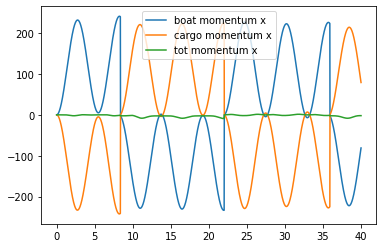

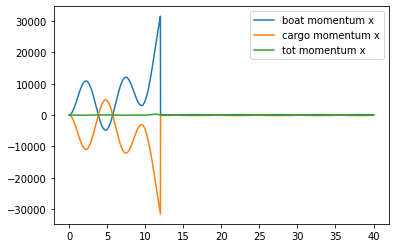

In [96]:
# [dtheta, domega, dx_C, dv_Cx, dy_C, dv_Cy, ds_L , dv_L]
print(m_L/m)
for i in range(2):
    px_boat  = w_vectors[i][3]*m
    px_cargo = w_vectors[i][7]*np.cos(w_vals[0])*m_L_factor_list[i]*m
    plt.plot(t_vals, px_boat, label="boat momentum x")
    plt.plot(t_vals, px_cargo, label="cargo momentum x")
    plt.plot(t_vals, px_boat+px_cargo, label="tot momentum x")
    plt.legend()
    plt.show()

<a class="anchor" id="anim1"></a>

| | |
:-------------------------:|:-------------------------:
![](animations/fence_mL=0.001m.gif) | ![](animations/fence_mL=0.08m.gif)

***Animation 4***: The motion of boats with fences for the same cargo-masses as before.*


**WHAT TO PLOT???**

## Boat with friction and harmonic wave/wind-force <a class="anchor" id="w-force"></a>

Next we will study how wind or waves and friction between the water and the hull, might effect the dynamics of the ship. Since we are mainly interested in how these considerations affects the ship, we will once again assume there is no cargo aboard the ship in this section. Our models for friction and the harmonic force representing wind or waves is given in section **section**. Our new system becomes:

$$ \frac{\textrm{d}}{\textrm{d}t} \begin{bmatrix} \theta(t) \\
                           \omega(t) \\
                           x_C(t) \\
                           v_{C, x}(t) \\
                           y_C(t) \\
                           v_{C, y}(t) \\
                           s_L(t) \\
                           v_{L}(t)\end{bmatrix} 
= \begin{bmatrix} \omega(t) \\ 
                  (\tau_B(t)+\tau_f(t)+\tau_{F_w})/I_C \\
                  v_{C, x}(t) \\
                  (f(t)+F_w(t)) / m \\
                  v_{C, y}(t) \\
                  (F_B(t)+F_G)/m \\
                  0\\
                  0\end{bmatrix}.
$$

In [97]:
# 2f + 2g
def f_wind_friction(t, w):
    """
    brief: the derivative of the vector w, now without cargo with 
    friction and harmonic wawe/wind force
    :param t: current time
    :param w: 8D array with current theta, omega, x, vx, y, vy, s, vs
    :return: 8D array with derivatives of the above parametres
    NB: k_f, F_0 og omega_w must be defined before calling the function
    """
    
    gamma = find_gamma(w[0], w[4])
    A     = find_A(gamma)
    F_B   = find_F_buoyant(A)
    tau_B = find_tau_buoyant(w[0], F_B)
    f     = find_F_friction(gamma, w[1], k_f)
    tau_f = find_tau_friction(w[4], gamma, f)
    F_w   = find_F_waves_wind(t, F_0, omega_w)
    tau_w = find_tau_waves_wind(w[4], F_w)
    
    dtheta = w[1]
    domega = (tau_B + tau_f + tau_w)/I_C
    dx_C   = w[3]
    dv_Cx  = (f + F_w)/m
    dy_C   = w[5]
    dv_Cy  = (F_B + F_G())/m
    return np.array([dtheta, domega, dx_C, dv_Cx, dy_C, dv_Cy, 0, 0])

**Calm waters**

To see the effects of the friction we will first assume the waters are calm and there is no wind, meaning the harmonic force will be set to zero.

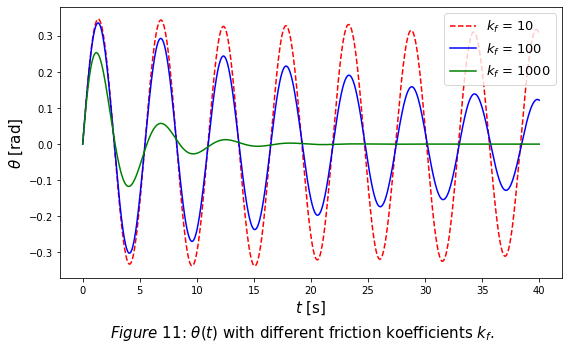

In [98]:
# 2f

t0    = 0
t_end = 40
h     = 0.01
w0 = [0, 0.4, 0, 0, yC0, 0, 0, 0]
F_0, omega_w = 0, 0 # Calm waters before the storm (:
k_f_list = [10, 100, 1000]

times  = []
thetas = []
for i in range(len(k_f_list)):
    k_f = k_f_list[i]
    t_vals, w_vals = ode_solver(f_wind_friction, t0, t_end, w0, h, method=RK4_method)
    times.append(t_vals)
    thetas.append(w_vals[0])

#     animate_boat(t_vals, w_vals[0], w_vals[2], w_vals[4], w_vals[6], title = r"$k_f=$ " + f"{k_f}", gif_name = f"water_friction_kf={k_f}")  
       
plot_function(times, thetas, fig_text = r"$\theta(t)$ with different friction koefficients $k_f$.", 
              linestyles = ['r--', 'b', 'g'], title_size=20, labels = [r"$k_f$ = " + f"{k_f}" for k_f in k_f_list])


As we can see from figure **Figure** the amplitude of  seems to decrease over over time. For $k_f = 10$ there is no noticeable change in amplitude, but for $k_f = 100$ and $k_f = 1000$ one can see a decrease in amplitude while the frequency seems to be unchanged. It is clear that the amplitude decreases faster for larger values of $k_f$. This happens because the torque generated by the friction is always working against the rotation. Effectively turning the system in to a dampened oscillator. Since friction decreases the maximum values for , it should also lower the chances of capsizing. In addition the friction causes the center of mass to sway from left to right, but only to a small exctent which is barely noticeable even for $k_f =1000$.

<a class="anchor" id="anim1"></a>

| | |
:-------------------------:|:-------------------------:
![](animations/water_friction_kf=10.gif) | ![](animations/water_friction_kf=100.gif)

***Animation 5***: The motion of the boat for two different friction koefficients $k_f$.*

  0%|          | 0/100 [00:00<?, ?it/s]

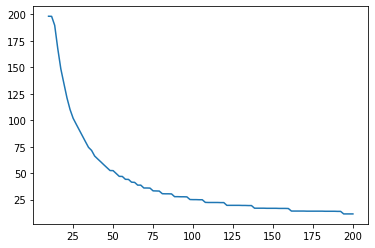

In [99]:
### INTERESSANT Å SE PÅ??
N = 100
k_f_array = np.linspace(10, 200, N)
half_time = np.zeros(N)
w0 = [0.3, 0, 0, 0, yC0, 0, 0, 0] # [theta0, omega0, x0, vx0, y0, vy0, s0, vs0]
h  = 0.1
t0 = 0
t_end = 200

for i in tqdm(range(N)):
    k_f = k_f_array[i]
    t_vals, w_vals = ode_solver(f_wind_friction, t0, t_end, w0, h, method=RK4_method)
    theta_amplitude = abs(w_vals[0])
    for j in range(len(t_vals)):
        if max(theta_amplitude[j::]) < 1/2 * w0[0]:
            half_time[i] = h*j
            break
                                                             
plt.plot(k_f_array, half_time)

## KANSKJE finne en bedre indikator på henfall... Her får vi hopp når det skjer en topp tidligere.

***Discussing how ampltude reduction depends on k_f???***

**Harmonic wawe/wind-force**

Next we will also be taking into account the harmonic force representing wind or waves.

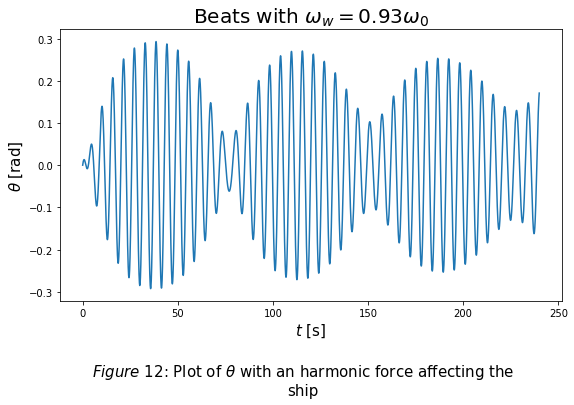

In [100]:
# 2g

t0 = 0
t_end = 240
h = 0.01
w0 = [0, 2*np.pi/180, 0, 0, yC0, 0, 0, 0]
k_f = 10
F_0 = 0.625*m*g
omega_w_scale_factor = 0.93
omega_w = omega_w_scale_factor*np.sqrt(m*g*h_CM/I_C)

t_vals, w_vals = ode_solver(f_wind_friction, t0, t_end, w0, h, method=RK4_method)
plot_function([t_vals], [w_vals[0]], title = r"Beats with $\omega_w=$" + f"{omega_w_scale_factor}" + r"$\omega_0$",
              fig_text = r"Plot of $\theta$ with an harmonic force affecting the ship", fig_text_y=-0.13, linestyles = [], title_size=20,
              labels = False, loc = "upper right")

# animate_boat(t_vals, w_vals[0], w_vals[2], w_vals[4], w_vals[6], 
#              title = r"$\omega_w=$ " + f"{omega_w_scale_factor}" + r"$\omega_0$", 
#              gif_name = f"beats_omega_w={omega_w_scale_factor}omega_0") 



With our initial conditions and the given values for $k_f$, $F_0$ and $\omega_w$, we notice the phenomenon known as beats. This happens when a harmonic force is applied to an oscillating system with a natural frequency close to, but not equal, to the frequency of the harmonic force. The difference in frequency causes periods of constructive interference, where the amplitude of $\theta$ increases, and periods of destructive inteference where the amplitude decreases. If the frequencies were equal the amplitude of $\theta$ would likely keep increasing and cause the ship to capsize, given that the friction is not too great.

We not take a look at the animation to get a more complete impression of the ship's motion.

![](animations/beats_omega_w=0.93omega_0.gif)

***Animation 6***: The motion of a ship affected by weak friction and a strong harmonic wind force close to its natural frequency.*

***Discuss how the friction due to translation ...*** Also tunnelling through water...

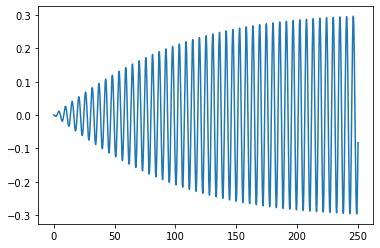

In [101]:

t0 = 0
t_end = 250
w0 = [0, 0, 0, 0, yC0, 0, 0, 0]
h = 0.01
F_0 = 0.1*m*g
omega_w_scale_factor = 1
omega_w = omega_w_scale_factor*np.sqrt(m*g*h_CM/I_C)
k_f = 10

t_vals, w_vals = ode_solver(f_wind_friction, t0, t_end, w0, h, method=RK4_method)

plt.plot(t_vals, w_vals[0])
plt.show()

## Comparing RK4 with an adaptive solver <a class="anchor" id="adaptive"></a>

RK4, the ode-method we've used in the last couple of paragraphs, has it's strengths and weaknesses. The main reason physicists like to use the method is its simplicity in implementation. However, there are some key drawbacks to the method:
<ol>
    <li>Adaptive methods estimate the local error during the algorithm and adjusts the stepsize accordingly. This often results in fewer steps made without a significant loss in accuracy. The RK4 method is not adaptive.
    <li>Single step ode-solvers like RK4, aren't able to solve stiff ode's. This is a limitation of grave importance, as many important system in the physical world can only be modelled by equations that are stiff in nature.
</ol>

To analyze the validity of our RK4 implementation, and to delve deeper into the problems metioned above, we'll compare our ode_solver with scipy.intergrate.solve_ivp's BDF method. This is an adaptive and implicit algorithm, so it should not be sensitive to any (if present) stiffness in our system.

Consider the example of the last section, where a harmonic force (like wind or waves) drives the movement of the boat. From elementary wave mechanics, we know the phenomenon of resonance can occur when the frequency of such a force approaches the eigenfrequency of the boat. Resonance is a major issue, which can be seen below.


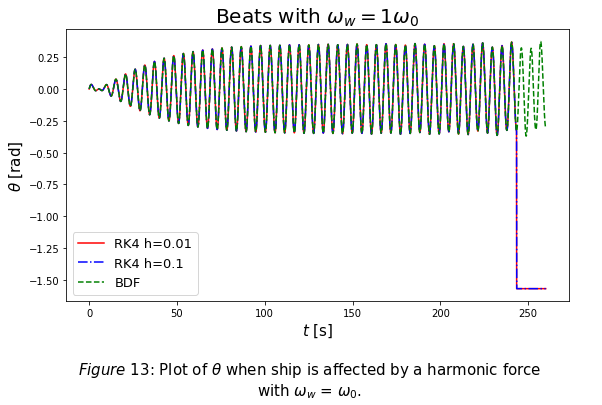

Our RK4 with h=0.01 capsized the boat at t= 243.35999999992364, #steps = 26001
Our RK4 with h=0.1 capsized the boat at t= 243.39999999999046, #steps=2601
Scipys adaptive BDF capsized the boat at t= 243.36745040831883, #steps=5595


In [102]:
def first_capsized(tvals, wvals):
    
    for time, theta, y in zip(tvals, wvals[0], wvals[4]):
        if (boat_has_capsized(theta, y)):
            return time
    return -1

t0 = 0
t_end = 260
h1 = 0.1
h2 = 0.01
w0 = [0, 3*np.pi/180, 0, 0, yC0, 0, 0, 0]
k_f = 10
F_0 = 0.3*m*g
omega_w_scale_factor = 1
omega_w = omega_w_scale_factor*np.sqrt(m*g*h_CM/I_C)

data = solve_ivp(f_wind_friction, (t0, t_end), w0, method='BDF', atol=1.0e-12, rtol=1.0e-6)
t_BDF, w_BDF = data.t, data.y 
t_vals001, w_vals001 = ode_solver(f_wind_friction, t0, t_end, w0, h2, method=RK4_method) 
t_vals01, w_vals01 = ode_solver(f_wind_friction, t0, t_end, w0, h1, method=RK4_method) 

plot_function([t_vals001, t_vals01, t_BDF], [w_vals001[0], w_vals01[0], w_BDF[0]],
              title = r"Beats with $\omega_w=$" + f"{omega_w_scale_factor}" + r"$\omega_0$" ,
              fig_text = r"Plot of $\theta$ when ship is affected by a harmonic force with $\omega_w$ = $\omega_0$.", fig_text_y=-0.13, linestyles = ['r-', 'b-.', 'g--'], title_size=20,
              labels = [f"RK4 h={h2}", f"RK4 h={h1}", "BDF"], loc = "lower left")




print(f'Our RK4 with h={h2} capsized the boat at t= {first_capsized(t_vals001, w_vals001)}, #steps = {len(t_vals001)}')
print(f'Our RK4 with h={h1} capsized the boat at t= {first_capsized(t_vals01, w_vals01)}, #steps={len(t_vals01)}')
print(f'Scipys adaptive BDF capsized the boat at t= {first_capsized(t_BDF, w_BDF)}, #steps={len(t_BDF)}')

Even when $\omega (t=0) = 3^\circ/s$, the boat will eventually capsize. Every boat is subject to this effect, and it is therefore interesting to know how long a boat can withstand harmonic forces like these. We see that our RK4 method produces roughly the same $t\approx 243.36$ as scipys BDF method before it capsizes. However, the amount of steps needed to produce this result is very different. Being an implicit method BDF will, of course, have more overhead per iteration than an explicit method. Even so, it is important to note the accuraccy of the BDF method compared to the RK4 method with only 1/5 the number of steps. 

If a boat builder asked ous how many seconds the boat would remain floating, we could reproduce the answer with step-size h=0.1, but how could we check the validity of this answer? The interval is sufficiently long (4 minutes), so the error could be quite large even if the step size is as small as 0.1. To be able to answer more confidently, we would have to rerun the algorithm with a smaller step-size, and compare the answers. In this example, the difference is minute and irrelevant, but in general, the difference between the h=0.1 and h=0.01 time_to_capsize could've been non-negligible. 

An adaptive method on the other hand, estimates the error througout the process and compares it to a given tolerance. When this algorithm yields the answer 243.37, we know that it has varied the step size to make the error of each step rougly constant and beneathe a tolerance. The tolerance in our example is of order $\propto 10^{-6}$. With 5400 steps, the maximal possible error would be of order $5400\cdot 10^{-6} \approx 0.005$. This does not mean that the error in the time_to_capsize is of order 0.005, but rather that the total difference between the correct graph and this one is less thatn 0.005 radians. We could therefore be quite confident that the answer 243.37 is fairly close to the correct one. 

One aspect of adaptive algorithms is that you have no real influence on the total global error, only on the local ones. In the last example, we calculated an estimate of the total global error by multiplying the tolerance with the number of steps (a sort of worst-case scenario). However, there is no possible way of knowing how many steps the algorithm will take beforehand, so this estimate is not really applicable to determine the tolerance one should use.

In scipys solve_ivp, the tolerance is controlled by the numbers atol and rtol with tol=atol + rtol * abs(y), where y is the y-value (in this case $\theta$). In the last example, we set atol equal to $10^{-12}$, and rtol equal to $10^{-6}$. If we instead had used the default value of $10^{-6}$ for atol and $10^{-3}$ for rtol, this would happen:

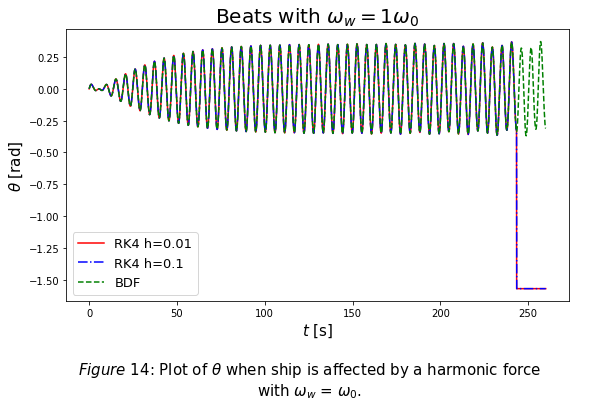

Our RK4 with h=0.01 capsized the boat at t= 243.35999999992364, #steps = 26001
Our RK4 with h=0.1 capsized the boat at t= 243.39999999999046, #steps=2601
Scipys adaptive BDF capsized the boat at t= 251.6256667543482, #steps=1871


In [103]:
t0 = 0
t_end = 260
h1 = 0.1
h2 = 0.01
w0 = [0, 3*np.pi/180, 0, 0, yC0, 0, 0, 0]
k_f = 10
F_0 = 0.3*m*g
omega_w_scale_factor = 1
omega_w = omega_w_scale_factor*np.sqrt(m*g*h_CM/I_C)

data = solve_ivp(f_wind_friction, (t0, t_end), w0, method='BDF', atol=1.0e-6, rtol=1.0e-3)
t_BDF, w_BDF = data.t, data.y 
t_vals001, w_vals001 = ode_solver(f_wind_friction, t0, t_end, w0, h2, method=RK4_method) 
t_vals01, w_vals01 = ode_solver(f_wind_friction, t0, t_end, w0, h1, method=RK4_method) 

plot_function([t_vals001, t_vals01, t_BDF], [w_vals001[0], w_vals01[0], w_BDF[0]],
              title = r"Beats with $\omega_w=$" + f"{omega_w_scale_factor}" + r"$\omega_0$" ,
              fig_text = r"Plot of $\theta$ when ship is affected by a harmonic force with $\omega_w$ = $\omega_0$.", fig_text_y=-0.13, linestyles = ['r-', 'b-.', 'g--'], title_size=20,
              labels = [f"RK4 h={h2}", f"RK4 h={h1}", "BDF"], loc = "lower left")




print(f'Our RK4 with h={h2} capsized the boat at t= {first_capsized(t_vals001, w_vals001)}, #steps = {len(t_vals001)}')
print(f'Our RK4 with h={h1} capsized the boat at t= {first_capsized(t_vals01, w_vals01)}, #steps={len(t_vals01)}')
print(f'Scipys adaptive BDF capsized the boat at t= {first_capsized(t_BDF, w_BDF)}, #steps={len(t_BDF)}')

The tolerance is now too large and the boat doesn't capsize for a long 8 second after it should. An estimate of the global error in this case yields $1838 \cdot rtol \cdot \theta_{max} = 1838 \cdot 10^{-3} \cdot 0.3 = 0.5613$ rad or a little over $30^\circ$. We don't claim that the error is of order $30^\circ$, but we have no way of knowing how large the error really is. This problem does not arise with our RK4 method, as the global error is proportional to $h^4$, så we can infer directly from the simulation with two different step sizes if the error is acceptable.

## Conclusion <a class="anchor" id="conclusion"></a>

We have found, we have shown

## KODEBANK, søppel++

In [104]:
IKKE kjør søppel takk

# def victor():
#     def func(x, y):
#         val = 2.8*x**2 * (x**2*(2.5*x**2+y**2-2)+1.2*y**2 * (y*(3*y-0.75)-6.0311)+3.09)+0.98*y**2 * ((y**2-3.01)*y**2+3)-1.005
#         return abs(val) < 0.02
#     n = 3000
#     x = np.linspace(-2, 2, n)
#     y = np.linspace(-2, 2, n)
#     grid = np.zeros((n, n))
#     y, x = np.meshgrid(x, y)
#     z = func(x, y)
#     z = z[:-1, :-1]
#     z_min, z_max = 0, 1
#     fig, ax = plt.subplots()
#     c = ax.pcolormesh(x, y, z, vmin=z_min, vmax=z_max)
#     ax.set_title('Viktooooor')
#     ax.axis([x.min(), x.max(), y.min(), y.max()])
#     fig.colorbar(c, ax=ax)
#     plt.show()

# victor()


SyntaxError: invalid syntax (2974352997.py, line 1)

In [ ]:
t_end = 40

w0 = [0, 0.2, 0, 0, 0, 0, 3, 0]
t0 = 0
t_end = 40
m_L =0.08*m
t_vals, w_vals = ode_solver(f_cargo_without_fence, t0, t_end, w0, h, method=RK4_method)
cargo_offboard = find_cargo_offboard(w_vals[6])

# animate_boat(t_vals[::10], w_vals[0][::10], w_vals[2][::10], w_vals[4][::10], w_vals[6][::10], 
#              gjerde = False, vis_akse_verdier = False, gif_name="heavy_no_fence")
# plt.show()

plt.plot(t_vals, w_vals[0])
if (cargo_offboard != 0):
    plt.axvline(t_vals[cargo_offboard])

t0 = t_vals[cargo_offboard+1]
w0 = np.transpose(w_vals)[cargo_offboard+1]
t2_vals, w2_vals = ode_solver(f_bouncing, t0, t_end, w0, h, method=RK4_method)
plt.plot(t2_vals, w2_vals[0], 'r--')
plt.show()


# plt.plot(t_vals, w_vals[6])
# if (cargo_offboard != 0):
#     plt.axvline(t_vals[cargo_offboard])
# plt.show()

# SER BRA UT
plt.plot(t_vals, -g*np.sin(w_vals[0]))
plt.plot(t_vals, np.gradient(w_vals[7])*1/h, "g--")


In [ ]:

t_end = 200

w0 = [0, 0.2, 0, 0, 0, 0, 3, 0]
m_L = 0.00001*m
t_vals, w_vals = ode_solver(f_cargo_with_fence, t0, t_end, w0, h, method=RK4_method)
theta = w_vals[0]
s_L = w_vals[6]
#animate_boat(t_vals[::10], theta[::10], xC[::10], yC[::10], gjerde = True, vis_akse_verdier = False)

plt.plot(t_vals, w_vals[6])
plt.show()

plt.plot(t_vals, w_vals[7])
plt.show()


#animate_boat(t_vals[::10], w_vals[0][::10], w_vals[2][::10], w_vals[4][::10], w_vals[6][::10], gjerde = True, vis_akse_verdier = False, gif_name = "heavy")

# m_L =0.08*m
# t_vals, w_vals = ode_solver(f_cargo_with_fence, t0, t_end, w0, h, method=RK4_method)
# theta = np.transpose(w_vals)[0]
# s_L = np.transpose(w_vals)[6]

# plt.plot(t_vals, theta)
# plt.show()
# plt.plot(t_vals, s_L)
# plt.show()

# At = t_vals
# Atheta = np.transpose(w_vals)[0]
# Ax_C = np.transpose(w_vals)[2]
# Ay_C = np.transpose(w_vals)[4]
# As_L = np.transpose(w_vals)[6]
# animate_boat(At[::10], Atheta[::10], Ax_C[::10], Ay_C[::10], As_L, gjerde = True, vis_akse_verdier = False, gif_name = "heavy")

In [ ]:
t0 = 0
t_end = 3

w0 = [0, 0, 0, 0, 0, 0, 0, 0]
m_L = 0.99*m
t_vals, w_vals = ode_solver(f_cargo_with_fence, t0, t_end, w0, h, method=RK4_method)
theta = w_vals[0]
s_L = w_vals[6]

plt.plot(t_vals, w_vals[4])
plt.show()

plt.plot(t_vals, w_vals[7])
plt.show()


animate_boat(t_vals, w_vals[0], w_vals[2], w_vals[4], w_vals[6], 
             gjerde = True, vis_akse_verdier = False, gif_name = "sink")


$\eqref{eq:HO_tau}$ **MÅ FINNE UT AV LIKNINGSNUMMER**

$$
\begin{equation}
\sum{\tau} = I_C \ddot{\theta} = \tau_C(\theta). \\
\label{eq:HO_tau}
\end{equation}
$$



We introduce the angular velocity $\omega = \dot{\theta}$ and split the problem into a system of first order equations:

$$
\begin{align*}
\frac{\textrm{d}\theta}{\textrm{d}t} &= \omega \\ 
\frac{\textrm{d}\omega}{\textrm{d}t} &= \frac{\tau_C(\theta)}{I_C}. \\
\end{align*}
$$

Introducing the vector $\vec{w} = \begin{bmatrix} \theta(t) & \omega(t) \end{bmatrix}^T$ we can write our problem on the standard form $\frac{\textrm{d}\vec{w}}{\textrm{d}t} = \vec f(t, \vec w) $:

$$ \frac{\textrm{d}}{\textrm{d}t} \begin{bmatrix} \theta(t) \\ \omega(t) \end{bmatrix} 
= \begin{bmatrix} \omega \\ - \frac{F_B h_{CM}}{I_C} \sin{\theta}\end{bmatrix}.$$

The variable $F_B$ is given by:

$$F_B = \sigma_0 A_0 g = \frac{\sigma_0gR^2}{2} (\beta - \sin{\beta}) $$ 

In [ ]:
## FORSLAG 

# Gjøre løseren adaptiv

# Går det an å lage en stiv likning med båten???
    # SETT BÅTEN MELLOM 2 vegger??
    # Modellere veggen som en ideel fjær med k = 1000000000?
    
    #### Vakre forslag gutta. Implementerte en versjon i scipy, så vi kan sammenligne: 
    # Denne bruker RK45, så er adaptiv
    
from scipy.integrate import solve_ivp


w0 = [0, 0.2, 0, 0, 0, 0, 3, 0]
t0 = 0
t_end = 40

vals = solve_ivp(f_cargo_with_fence, (t0, t_end), w0, method='RK45')
tvals, yvals = vals.t, vals.y
plt.plot(tvals, yvals[4])

### Tror animasjon funker dårlig her... Vanskelig å få til at tid på anim stemmer med virkelighet når h varierer
# animate_boat(t_vals, w_vals[0], w_vals[2], w_vals[4], 
#          w_vals[6], title = r"$\omega_w=$ " + f"{omega_w_scale_factor}" + r"$\omega_0$", 
#          gif_name = f"scipy_implementation={omega_w_scale_factor}omega_0") 